In [54]:
"""
Build chunks with different sizes (e.g., 256/512/1024 tokens [approx words]).
- Compare retrieval performance across chunk sizes.
- Try Fusion Retriever: BM25 + Embedding (late fusion with weighted sum).
"""

'\nBuild chunks with different sizes (e.g., 256/512/1024 tokens [approx words]).\n- Compare retrieval performance across chunk sizes.\n- Try Fusion Retriever: BM25 + Embedding (late fusion with weighted sum).\n'

In [22]:
import os
os.environ["TRANSFORMERS_NO_TF"]="1"
os.environ["TRANSFORMERS_NO_FLAX"]="1"

In [23]:
from pathlib import Path
import shutil, os

In [55]:
# 1) set your file path (absolute path is safest)

In [74]:
#get current working directory
root = Path.cwd()
# set the source file using relative path (go 2 levels up, then into 11_data)
src = Path("../../../11_data/01 Harry Potter and the Sorcerers Stone.txt")
#make a "corpus" folder inside current working directory
corpus_dir = root / "corpus"
corpus_dir.mkdir(exist_ok=True, parents=True)

In [75]:
#check the source file really exists, stop if nots
assert src.exists(), f"File not found: {src}"


# copy the file into the corpus folder (only if not already copied)
dst = corpus_dir / src.name
if not dst.exists():
    shutil.copy2(src, dst)
dst, list(p.name for p in corpus_dir.glob("*"))

(PosixPath('/Users/jessicahong/gitclone/NLP_study/15_llm/Applications/RAG/corpus/01 Harry Potter and the Sorcerers Stone.txt'),
 ['01 Harry Potter and the Sorcerers Stone.txt'])

In [77]:
# 3) simple loader for utf-8 txt files
def load_txt(path: Path) -> str:
    """Read a UTF-8 text file and return as a string"""
    return path.read_text(encoding="utf-8", errors="ignore")

# check again that the file exists (optional, for debugging)
print(src.exists(), src)

True ../../../11_data/01 Harry Potter and the Sorcerers Stone.txt


In [78]:
# 4) actually read the text into memory
text = load_txt(src)

# show number of characters and preview
print("num chars:", len(text))
print("\n=== preview (first 600 chars) ===\n", text[:600])


num chars: 439478

=== preview (first 600 chars) ===
 M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense.

Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, sp


In [79]:
# --- Clean up the raw text ---

import re, unicodedata

def normalize_text(t: str) -> str:
    # 1) normalize unicode (e.g., full-width to normal width)
    t = unicodedata.normalize("NFKC", t)

    # 2) replace multiple spaces or tabs with a single space
    t = re.sub(r"[ \t]+", " ", t)

    # 3) if there are 3 or more newlines, shrink to just 2 newlines
    t = re.sub(r"\n{3,}", "\n\n", t)

    # 4) remove extra spaces at start and end
    return t.strip()

# apply the cleaning function
text = normalize_text(text)

In [81]:
# check new length and preview first 400 characters
print("num chars after clean:", len(text))
print(text[:400])

num chars after clean: 439606
M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense.

Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he d


In [65]:
#chunking by words
# we split the text into pieces (chunks) of N words
# to keep some context, we overlap chunks by a small amount

In [82]:
from typing import List

# pattern to split into words and punctuation
WORD_SPLIT = re.compile(r"\w+|[^\w\s]")  

def simple_tokenize(t: str) -> List[str]:
    """Turn text into a list of lowercase tokens (words + punctuation)."""
    return WORD_SPLIT.findall(t.lower())


In [83]:
def chunk_by_words(text: str, chunk_size: int = 512, overlap: int = 50) -> List[str]:
    """
    Split text into chunks by word count.
    - Each chunk has about `chunk_size` words
    - Neighbor chunks overlap by `overlap` words
    """
    # 1) tokenize the text
    words = simple_tokenize(text)
    chunks = []

    # 2) step size = chunk_size - overlap
    step = max(1, chunk_size - overlap)

    # 3) slide through the words list with this step size
    for i in range(0, len(words), step):
        # take words from i to i+chunk_size
        w = words[i:i+chunk_size]
        if not w:
            break

        # 4) join words back into a string (collapse spaces)
        chunk = re.sub(r"\s+", " ", " ".join(w)).strip()
        chunks.append(chunk)

        # 5) stop if we reach the end
        if i + chunk_size >= len(words):
            break

    return chunks

In [84]:
# --- Test the chunking function ---

# choose chunk sizes to compare
CHUNK_SIZES = [256, 512, 1024]
OVERLAP = 50

chunked_map = {}
for sz in CHUNK_SIZES:
    ch = chunk_by_words(text, chunk_size=sz, overlap=OVERLAP)
    chunked_map[sz] = ch
    print(f"chunk_size={sz} -> number of chunks: {len(ch)}")

# preview: show the first 1–2 chunks for each size
for sz in CHUNK_SIZES:
    print(f"\n=== Sample from chunk_size={sz} ===")
    print("Chunk 0:", chunked_map[sz][0][:200], "...")
    if len(chunked_map[sz]) > 1:
        print("Chunk 1:", chunked_map[sz][1][:200], "...")


chunk_size=256 -> number of chunks: 502
chunk_size=512 -> number of chunks: 224
chunk_size=1024 -> number of chunks: 107

=== Sample from chunk_size=256 ===
Chunk 0: m r . and mrs . dursley , of number four , privet drive , were proud to say that they were perfectly normal , thank you very much . they were the last people you ’ d expect to be involved in anything  ...
Chunk 1: sister , but they hadn ’ t met for several years ; in fact , mrs . dursley pretended she didn ’ t have a sister , because her sister and her good - for - nothing husband were as undursleyish as it was ...

=== Sample from chunk_size=512 ===
Chunk 0: m r . and mrs . dursley , of number four , privet drive , were proud to say that they were perfectly normal , thank you very much . they were the last people you ’ d expect to be involved in anything  ...
Chunk 1: . dursley as he left the house . he got into his car and backed out of number four ’ s drive . it was on the corner of the street that he noticed the first 

In [85]:
import pandas as pd
from pathlib import Path

# 1) make an output folder (rag_lab_outputs)
out_dir = Path("rag_lab_outputs")
out_dir.mkdir(exist_ok=True, parents=True)

# 2) collect chunk info into a list of dicts
rows = []
for sz, chunks in chunked_map.items():
    for i, ch in enumerate(chunks):
        rows.append({
            "doc_name": src.name,                     # which file
            "chunk_size": sz,                         # size setting
            "chunk_idx": i,                           # index number
            "chunk_preview": ch[:160].replace("\n"," "), # first 160 chars
            "chunk_len_words": len(simple_tokenize(ch)), # number of words
        })

# 3) convert list into a pandas DataFrame (table)
df = pd.DataFrame(rows)

# 4) save DataFrame to CSV file
csv_path = out_dir / "chunking_summary.csv"
df.to_csv(csv_path, index=False, encoding="utf-8")

print("✅ saved to:", csv_path)

# 5) show the first 8 rows as a quick preview
df.head(8)


✅ saved to: rag_lab_outputs/chunking_summary.csv


,doc_name,chunk_size,chunk_idx,chunk_preview,chunk_len_words
0,01 Harry Potter and the Sorcerers Stone.txt,256,0,"m r . and mrs . dursley , of number four , pri...",256
1,01 Harry Potter and the Sorcerers Stone.txt,256,1,"sister , but they hadn ’ t met for several yea...",256
2,01 Harry Potter and the Sorcerers Stone.txt,256,2,", mr . dursley picked up his briefcase , pecke...",256
3,01 Harry Potter and the Sorcerers Stone.txt,256,3,"said privet drive — no , looking at the sign ;...",256
4,01 Harry Potter and the Sorcerers Stone.txt,256,4,- green cloak ! the nerve of him ! but then it...,256
5,01 Harry Potter and the Sorcerers Stone.txt,256,5,and walk across the road to buy himself a bun ...,256
6,01 Harry Potter and the Sorcerers Stone.txt,256,6,. he put the receiver back down and stroked hi...,256
7,01 Harry Potter and the Sorcerers Stone.txt,256,7,that the man was wearing a violet cloak . he d...,256


In [87]:
# --- Simple statistics by chunk size ---

# 1) count how many chunks were created for each chunk_size
cnt = (
    df.groupby("chunk_size")["chunk_idx"]
      .count()
      .rename("num_chunks")
      .reset_index()
)

# 2) compute the average number of words in chunks (rounded to 1 decimal)
avg = (
    df.groupby("chunk_size")["chunk_len_words"]
      .mean()
      .round(1)
      .rename("avg_words")
      .reset_index()
)

# 3) print the tables
print("=== number of chunks ===\n", cnt, "\n")
print("=== average words per chunk ===\n", avg)


=== number of chunks ===
    chunk_size  num_chunks
0         256         502
1         512         224
2        1024         107 

=== average words per chunk ===
    chunk_size  avg_words
0         256      255.9
1         512      511.4
2        1024     1015.9


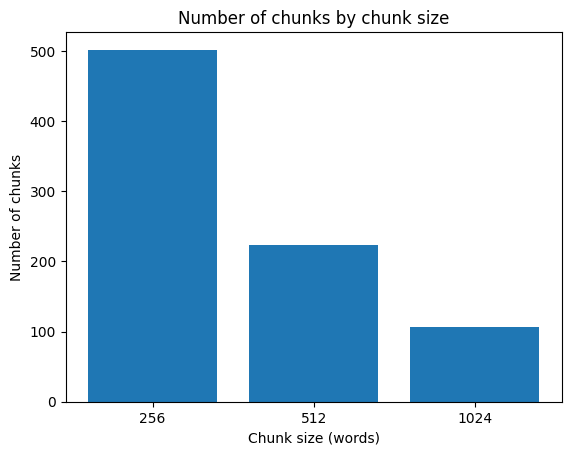

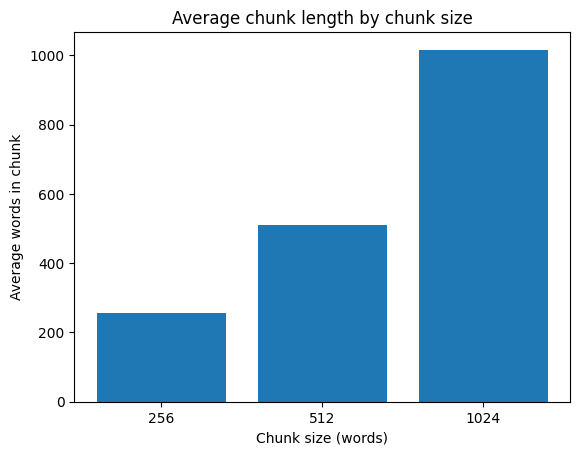

In [88]:
import matplotlib.pyplot as plt

# --- Plot number of chunks per chunk_size ---
plt.bar(cnt["chunk_size"].astype(str), cnt["num_chunks"])
plt.xlabel("Chunk size (words)")
plt.ylabel("Number of chunks")
plt.title("Number of chunks by chunk size")
plt.show()

# --- Plot average words per chunk_size ---
plt.bar(avg["chunk_size"].astype(str), avg["avg_words"])
plt.xlabel("Chunk size (words)")
plt.ylabel("Average words in chunk")
plt.title("Average chunk length by chunk size")
plt.show()
